<a href="https://colab.research.google.com/github/artbrgn/DS-Unit-2-Applied-Modeling/blob/master/module3/Copy_of_assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [18]:
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
import pandas as pd
# import plotly_express as px
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

Using TensorFlow backend.


In [4]:
from google.colab import files
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv


In [5]:
gender = pd.read_csv('gender_submission.csv')
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [6]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [7]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [9]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
train = train.dropna()

In [12]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [0]:
test = test.dropna()

In [14]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [15]:
train, val = train_test_split(train, random_state=42)
train.shape, val.shape, test.shape

((137, 12), (46, 12), (87, 11))

In [16]:
val.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [0]:
target = 'Survived'
X_train = train.drop(columns=[target])
y_train = train[target]
X_val = val.drop(columns=[target])
y_val = val[target]
X_test = val.drop(columns=[target])
y_test = val[target]

In [28]:
# using previous year lifespan, as y_pred = y_baseline
y_baseline = pd.Series(train['Survived'], index=train.index)
# # using previous year lifespan, as y_pred = y_baseline to try to find a better model fit
mean_baseline = train['Survived'].mean()
y_pred = val['Survived']
baseline_mae = mean_absolute_error(y_val, y_pred)
print('mean baseline:', train['Survived'].mean())
print(f'Mean Absolut Error of the baseline prediction (predict Survived): {baseline_mae:.4f}')

mean baseline: 0.6934306569343066
Mean Absolut Error of the baseline prediction (predict Survived): 0.0000


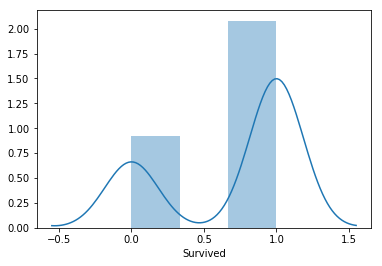

In [29]:
sns.distplot(y_train);

In [30]:
pipeline = make_pipeline(
ce.OrdinalEncoder(),
XGBRegressor(learning_rate=0.1,
             max_depth=7, n_estimators=2000,
             n_jobs=-1, objective='reg:linear')
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

[14:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolut error: 0.35313316855741583


In [31]:
pipeline = make_pipeline(
ce.OrdinalEncoder(),
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

[14:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolut error: 0.35313316855741583


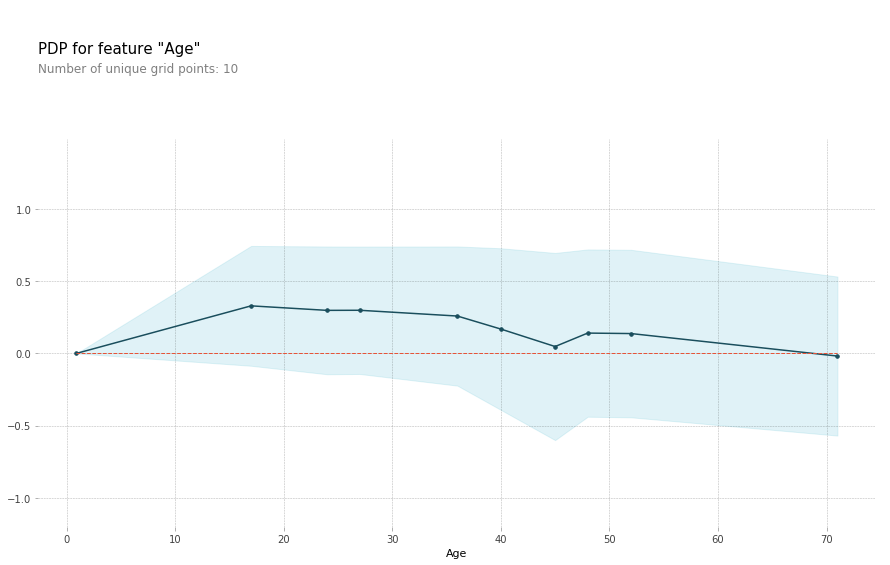

In [35]:
feature = 'Age'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

ValueError: ignored

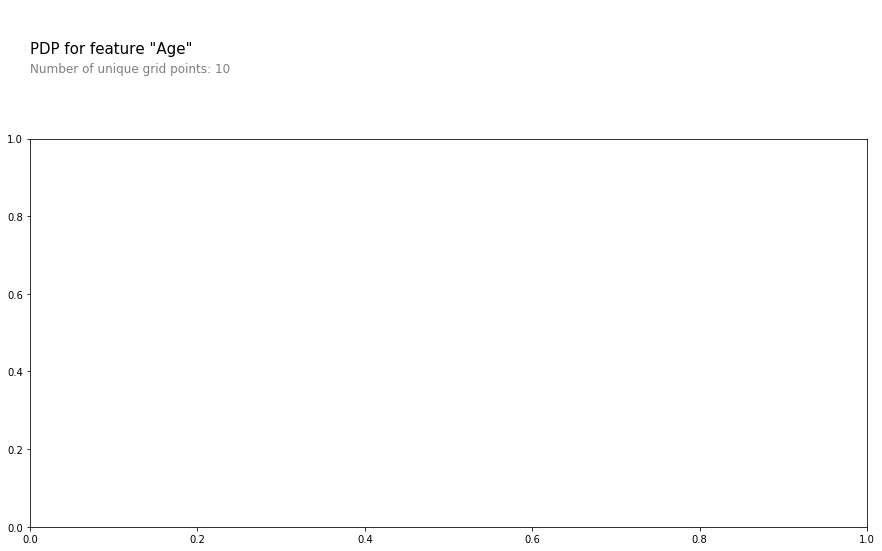

In [36]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=150)
plt.xlim(0,1000);

ValueError: ignored

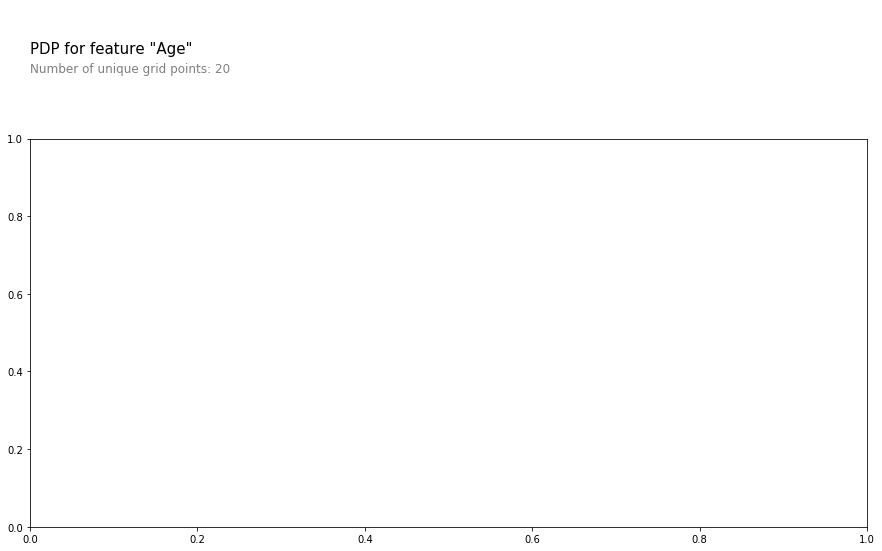

In [37]:

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns,
    feature=feature, 
    num_grid_points=20
)
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=150) # Confusing parameter name
plt.xlim(0,550);

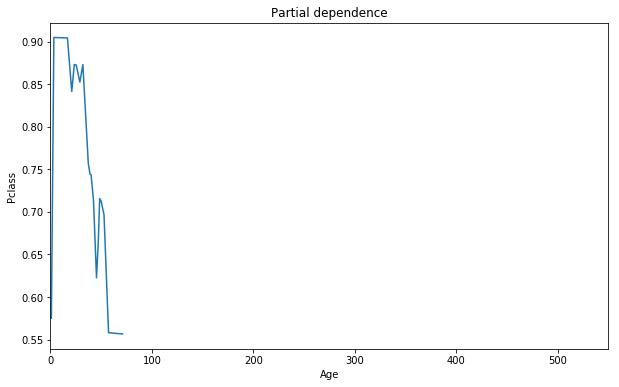

In [39]:
grid = isolated.feature_grids
pdp = isolated.pdp

plt.figure(figsize=(10,6))
plt.plot(grid, pdp)
plt.xlim(0,550)
plt.xlabel('Age')
plt.ylabel('Pclass')
plt.title('Partial dependence');